## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [ ]:
import tensorflow as tf
# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import os

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
# Opening JSON file 
f = open('./complaints-2021-05-14_08_16.json') # Write the path to your data file and load it 

# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [ ]:
# Inspect the dataframe to understand the given data.
display(df.head())
display(df.info())
display(df.describe(include='all'))

In [ ]:
#print the column names
df.columns

In [ ]:
#Assign new column names
df.columns = df.columns.str.lstrip('_')
df.columns = df.columns.str.replace('source.', '')
df.columns

In [ ]:
# Assign nan in place of blanks in the complaints column
df[df['complaint_what_happened'] ==''] = np.nan

In [ ]:
# df shape before dropna
print('df.shape before dropna =',df.shape)
#Remove all rows where complaints column is nan
df.dropna(subset='complaint_what_happened', inplace=True)
# df shape after dropna
print('df.shape after dropna =',df.shape)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


#### Convert data types

In [ ]:
df = df.convert_dtypes()
df.info()

#### Make the text lowercase

In [ ]:
# Write your function here to clean the text and remove all the unnecessary elements.
df['clean_complaints'] = df['complaint_what_happened'].str.lower()

#### Create function to extract regex

In [ ]:
def extract_regex(df, new_df, regexes):
    if not isinstance(regexes, list):
        regexes = [regexes]
    new_df = pd.DataFrame()
    for reg in regexes:
        if new_df.empty:
            new_df = pd.DataFrame(df[df['clean_complaints'].str.contains(reg, regex=True)]['clean_complaints'])            
        else:
            new_df = pd.concat([new_df, pd.DataFrame(df[df['clean_complaints'].str.contains(reg, regex=True)]['clean_complaints'])])
        
    # Apply the regular expressions to the DataFrame
    new_df['extracted'] = new_df['clean_complaints'].apply(lambda x: [match for regex in regexes for match in re.findall(regex, x)])
    # Display the 'extracted' column
    return pd.DataFrame((new_df['extracted']))

#### Remove text in square brackets

In [ ]:
df_square_brackets = pd.DataFrame()
regex = r'(\[.*?\])'
extract_regex(df, df_square_brackets, regex)

In [ ]:
df['clean_complaints'] = df['clean_complaints'].str.replace(regex, '', regex = True)

In [ ]:
extract_regex(df, df_square_brackets, regex)

#### Remove punctuation

In [ ]:
df_punctuation = pd.DataFrame()
regex = f'[{string.punctuation}]'
extract_regex(df, df_punctuation, regex)

In [ ]:
# Remove punctuation from 'clean_complaints'
df['clean_complaints'] = df['clean_complaints'].str.replace(regex, '', regex=True)

In [ ]:
extract_regex(df, df_punctuation, regex)

#### Remove words containing numbers

Filter words containing numbers anywhere

In [ ]:
# Create a new DataFrame that contains rows that have square brackets and its text
df_word_num = pd.DataFrame()

# Define the regular expressions
regex = [r'\b[A-Za-z]+\d+\w*\b', r'\b\d+[A-Za-z]+\w*\b']

extract_regex(df, df_word_num, regex).head(30)

Filter words containing numbers in between

In [ ]:
# Create a new DataFrame that contains rows that have square brackets and its text
df_word_num = pd.DataFrame()

# Define the regular expressions
regex = r'\b[A-Za-z]+\d+[A-Za-z]+\b'

extract_regex(df, df_word_num, regex).head(10)

Remove words containing numbers in between

In [ ]:
# Remove punctuation from 'clean_complaints'
df['clean_complaints'] = df['clean_complaints'].str.replace(regex, '', regex=True)

In [ ]:
extract_regex(df, df_word_num, regex).head(10)

#### Clean space

In [ ]:
print(df['clean_complaints'][1])

In [ ]:
# Removing leading/trailing whitespace and empty sentences
df['clean_complaints'] = df['clean_complaints'].apply(lambda x: '\n'.join(sent.strip() for sent in x.split('\n') if sent.strip() != ''))

In [ ]:
print(df['clean_complaints'][1])

In [ ]:
# Removing extra spaces between words.
df['clean_complaints'] = df['clean_complaints'].apply(lambda x: '\n'.join(' '.join(word.strip() for word in sent.split() if word.strip()!= '') for sent in x.split('\n') if sent.strip()!= ''))

In [ ]:
print(df['clean_complaints'][1])

#### Drop empty rows

In [ ]:
# df shape before dropna
print('df.shape before dropna =',df.shape)
#Remove all rows where complaints column is nan
df.dropna(subset='clean_complaints', inplace=True)
# Drop rows where column 'clean_complaints' is equal to ''
df = df[df['clean_complaints'] != '']
# df shape after dropna
print('df.shape after dropna =',df.shape)
# reset index
df.reset_index(drop=True, inplace=True)

#### Drop duplicates

In [ ]:
# df shape before drop_duplicates
print('df.shape before drop_duplicates =',df.shape)
# Drop duplicate rows based on column 'clean_complaints'
df = df.drop_duplicates(subset='clean_complaints')
# df shape after drop_duplicates
print('df.shape after drop_duplicates =',df.shape)

In [ ]:
if os.path.isfile('df.csv'):
  # load df_clean
  df = pd.read_csv('df.csv')
else:
    df.to_csv('df.csv', index=False)

#### Lemmatize the texts

In [2]:
#Write your function to Lemmatize the texts
def lemmatize(sent):        
    spacy.prefer_gpu()
    doc = nlp(sent)
    return ' '.join([token.lemma_ for token in doc])

In [15]:
if os.path.isfile('df_clean.csv'):
    #tag remote collab
    df = pd.read_csv('df.csv')
    # load df_clean
    df_clean = pd.read_csv('df_clean.csv')
else:
    #tag remote collab
    df = pd.read_csv('df.csv')

    #Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
    df_clean = pd.DataFrame()

    # initialize 'complaints' column
    df_clean['complaints'] = df['clean_complaints']

    # process 'complaints_lemmatized' column
    df_clean['complaints_lemmatized'] = pd.DataFrame(df_clean['complaints'].apply(lambda x: '\n'.join(lemmatize(sent) for sent in x.split('\n'))))

    # Store df_clean for later use
    df_clean.to_csv('df_clean.csv', index=False)

In [ ]:
print(df_clean['complaints_lemmatized'][0])

In [ ]:
df_clean

In [4]:
def pos_tag(text):
    # write your code here
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
    return lemmatize(' '.join([word for word, tag in pos_tags if tag.startswith('NN')]))

In [16]:
#Write your function to extract the POS tags 

if os.path.isfile('df_clean_v1.csv'):
  #tag remote collab
  df = pd.read_csv('df.csv')
  # load df_clean
  df_clean = pd.read_csv('df_clean_v1.csv')
  # Replace NaN values with an empty string
  df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].fillna('')
else:
  #tag remote collab
  df = pd.read_csv('df.csv')
  #tag remote collab
  df_clean = pd.read_csv('df_clean.csv')

  nltk.download('punkt')
  # Make sure you have the necessary NLTK data downloaded
  nltk.download('averaged_perceptron_tagger')

  df_clean['complaint_POS_removed'] = pd.DataFrame(df_clean['complaints'].apply(lambda x: '\n'.join(pos_tag(sent) for sent in x.split('\n'))))
  # Replace NaN values with an empty string
  df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].fillna('')
  # Store df_clean for later use
  df_clean.to_csv('df_clean_v1.csv', index=False)

In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [17]:
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace(r'xxxx*','', regex =True)
# Replace NaN values with an empty string
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].fillna('')

In [18]:
# Removing leading/trailing whitespace and empty sentences
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].apply(lambda x: '\n'.join(sent.strip() for sent in x.split('\n') if sent.strip() != ''))
# Removing extra spaces between words.
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].apply(lambda x: '\n'.join(' '.join(word.strip() for word in sent.split() if word.strip()!= '') for sent in x.split('\n') if sent.strip()!= ''))

In [ ]:
#All masked texts has been removed
df_clean

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length

# Create a new column 'complaint_length' that contains the length of each complaint
complaint_length = df_clean['complaints_lemmatized'].apply(len)

# Set the figure size
plt.figure(figsize=(13, 5))

# Plot a histogram of the complaint lengths
sns.histplot(complaint_length, edgecolor='white', bins=50, alpha=0.55, kde=True)
plt.xlabel('Complaint Length')
plt.ylabel('Frequency')
plt.title('Distribution of Complaint Lengths')
plt.show()

Distribution of complaint lengths is strongly right-skewed, indicating that most complaints are short, but there are a few very long ones that extend the range significantly.

#### Find the top 40 words by frequency among all the articles after processing the text.

In [19]:
# Get the list of English stop words
stop_words = nlp.Defaults.stop_words

# Create a new column with stop words removed
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
# Replace NaN values with an empty string
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].fillna('')

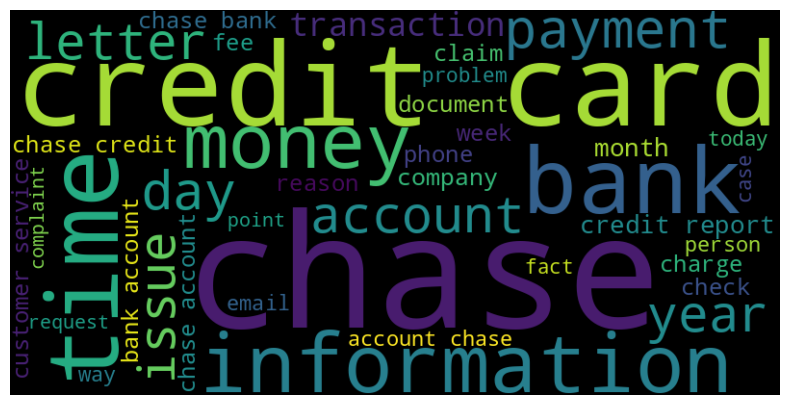

In [20]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud
# Combine all the complaints into a single string
all_complaints = ' '.join(df_clean['complaint_POS_removed'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, max_words=40).generate(all_complaints)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [23]:
#Removing -PRON- from the text corpus
# df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
if os.path.isfile('df_clean_v2.csv'):
  #tag remote collab
  df = pd.read_csv('df.csv')
  # load df_clean
  df_clean = pd.read_csv('df_clean_v2.csv')
  # Replace NaN values with an empty string
  df_clean['Complaint_clean'] = df_clean['Complaint_clean'].fillna('')
  df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].fillna('')
else:
  #tag remote collab
  df = pd.read_csv('df.csv')
  # load df_clean    
  df_clean = pd.read_csv('df_clean_v1.csv')
  # Replace NaN values with an empty string
  df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].fillna('')
  
  # Define a function to replace a token
  def remove_PRON(sent):
    spacy.prefer_gpu()
    doc = nlp(sent)
    return ' '.join([token.text for token in doc if token.pos_ !='PRON'])

  # Apply the function to the 'complaint_POS_removed' column
  df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].apply(remove_PRON)
  # Replace NaN values with an empty string
  df_clean['Complaint_clean'] = df_clean['Complaint_clean'].fillna('')

  df_clean.to_csv('df_clean_v2.csv', index=False)

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

- __Unigram__ means taking only one word at a time.
- __Bigram__ means taking two words at a time.
- __Trigram__ means taking three words at a time. 

Source: `https://www.analyticsvidhya.com/blog/2021/09/what-are-n-grams-and-how-to-implement-them-in-python/`

In [24]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned dataframe(df_clean). 
from nltk import ngrams, FreqDist

# Replace NaN values with an empty string
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].fillna('')

# Join all the complaints into a single string
all_words = ' '.join(df_clean['Complaint_clean']).split()

unigram_freq = FreqDist(all_words)

# Create a DataFrame from the result of word_freq.most_common(30)
df_unigram_freq = pd.DataFrame(unigram_freq.most_common(30), columns=['Unigram', 'Frequency'])

display (df_unigram_freq)

,Unigram,Frequency
0,chase,52879
1,account,46849
2,credit,32795
3,card,29618
4,bank,28337
5,payment,21066
6,time,13957
7,day,12902
8,charge,12229
9,check,12128


In [25]:
#Print the top 10 words in the unigram frequency
display(df_unigram_freq.head(10))

,Unigram,Frequency
0,chase,52879
1,account,46849
2,credit,32795
3,card,29618
4,bank,28337
5,payment,21066
6,time,13957
7,day,12902
8,charge,12229
9,check,12128


In [26]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

# Generate bigrams
bigrams = ngrams(all_words, 2)

bigram_freq = FreqDist(bigrams)

# Create a DataFrame from the result of word_freq.most_common(30)
df_bigram_freq = pd.DataFrame(bigram_freq.most_common(30), columns=['Bigram', 'Frequency'])

display (df_bigram_freq)

,Bigram,Frequency
0,"(credit, card)",12806
1,"(credit, report)",3850
2,"(account, chase)",3294
3,"(chase, credit)",3288
4,"(chase, account)",3133
5,"(chase, bank)",3101
6,"(customer, service)",3079
7,"(bank, account)",2997
8,"(account, account)",2724
9,"(check, account)",2209


In [27]:
#Print the top 10 words in the bigram frequency
display(df_bigram_freq.head(10))

,Bigram,Frequency
0,"(credit, card)",12806
1,"(credit, report)",3850
2,"(account, chase)",3294
3,"(chase, credit)",3288
4,"(chase, account)",3133
5,"(chase, bank)",3101
6,"(customer, service)",3079
7,"(bank, account)",2997
8,"(account, account)",2724
9,"(check, account)",2209


In [28]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

# Generate trigrams
trigrams = ngrams(all_words, 3)

trigram_freq = FreqDist(trigrams)

# Create a DataFrame from the result of word_freq.most_common(30)
df_trigram_freq = pd.DataFrame(trigram_freq.most_common(30), columns=['Trigram', 'Frequency'])

display (df_trigram_freq)

,Trigram,Frequency
0,"(chase, credit, card)",2170
1,"(credit, card, account)",1049
2,"(credit, card, company)",1005
3,"(credit, card, chase)",763
4,"(credit, card, credit)",523
5,"(account, credit, card)",475
6,"(inquiry, credit, report)",463
7,"(card, credit, card)",420
8,"(bank, credit, card)",416
9,"(credit, card, bank)",389


In [29]:
#Print the top 10 words in the trigram frequency
display(df_trigram_freq.head(10))

,Trigram,Frequency
0,"(chase, credit, card)",2170
1,"(credit, card, account)",1049
2,"(credit, card, company)",1005
3,"(credit, card, chase)",763
4,"(credit, card, credit)",523
5,"(account, credit, card)",475
6,"(inquiry, credit, report)",463
7,"(card, credit, card)",420
8,"(bank, credit, card)",416
9,"(credit, card, bank)",389


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [30]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df = 0.95, min_df = 2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [31]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

# Fit the TfidfVectorizer to the complaints column in df_clean and transform it into a Document Term Matrix (dtm)
dtm = tfidf.fit_transform(df_clean['Complaint_clean']) 
# dtm now holds the Document Term Matrix, which is a numerical representation of the text data

In [32]:
dtm.shape # Each row represents a document, and each column represents a word in the vocabulary

(20897, 7406)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [33]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [37]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state =40) #write your code here

In [38]:
W = nmf_model.fit_transform(dtm)
H = nmf_model.components_
len(tfidf.get_feature_names_out())

7406

In [39]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)], 
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,business,number,transaction,fee,customer,reason
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,debt,application,information,year,balance,letter
Topic 3,loan,mortgage,home,chase,modification,property,year,letter,rate,document,bank,foreclosure,house,sale,time
Topic 4,charge,card,chase,transaction,dispute,fraud,claim,merchant,purchase,fee,service,phone,email,time,day
Topic 5,payment,balance,fee,interest,month,statement,day,time,date,bill,auto,chase,year,account,rate


In [63]:
%%script echo 'skipped'
#Load your nmf_model with the n_components i.e 5
if os.path.isfile('df_topic_words.csv'):
    df = pd.read_csv('df.csv')
    # load df_clean
    df_clean = pd.read_csv('df_clean_v2.csv')
    # Replace NaN values with an empty string
    df_clean['Complaint_clean'] = df_clean['Complaint_clean'].fillna('')
    df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].fillna('')
    
    # load df_topic_words
    df_topic_words = pd.read_csv('df_topic_words.csv')
else: 
    df = pd.read_csv('df.csv')
    # load df_clean
    df_clean = pd.read_csv('df_clean_v2.csv')
    # Replace NaN values with an empty string
    df_clean['Complaint_clean'] = df_clean['Complaint_clean'].fillna('')
    df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].fillna('')
    
    from tqdm import tqdm
    df_topic_words = pd.DataFrame(columns=['num_topics']+[f'Word {i + 1}' for i in range(15)]).astype(str)
    num_topics_list = range(5,20+1)
    for i in tqdm(num_topics_list):
        num_topics = i #write the value you want to test out

        #keep the random_state =40
        nmf_model = NMF(n_components=num_topics, random_state =40) #write your code here
        # Fit the NMF model to the document-term matrix (dtm) and transform it into a matrix of topic weights (W)
        W = nmf_model.fit_transform(dtm) # shape (20897, 5)
        # Get the topic weights for each topic
        # This is a matrix where each row represents a topic, and each column represents a word in the vocabulary
        H = nmf_model.components_ # shape (5, 7406)
        len(tfidf.get_feature_names_out())

        #Print the Top15 words for each of the topics

        # vocabulary list
        words = np.array(tfidf.get_feature_names_out()) # shape(7406,)
        topic_words = pd.DataFrame(np.zeros((num_topics, 16)), index=[f'Topic {i + 1}' for i in range(num_topics)], 
                            columns=['num_topics']+[f'Word {i + 1}' for i in range(15)]).astype(str)

        for i in range(num_topics):
            # Get the indices of the top 15 words for the current topic
            ix = H[i].argsort()[::-1][:15] # shape(15,)
            # Assign the top 15 words to the current topic in the topic_words DataFrame
            topic_words.iloc[i] = [str(num_topics)] + [str(word) for word in words[ix]]

        df_topic_words = pd.concat([df_topic_words, topic_words])
    display(df_topic_words.head())
    df_topic_words.to_csv('df_topic_words.csv', index=False)

  0%|          | 0/16 [00:00<?, ?it/s]

 81%|████████▏ | 13/16 [01:31<00:24,  8.09s/it]/home/khang/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

 88%|████████▊ | 14/16 [01:45<00:19,  9.95s/it]/home/khang/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

 94%|█████████▍| 15/16 [02:02<00:12, 12.08s/it]/home/khang/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

100%|██████████| 16/16 [02:20<00:00,  8.79s/it]


,num_topics,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,5,account,check,bank,money,fund,chase,deposit,branch,day,business,number,transaction,fee,customer,reason
Topic 2,5,credit,card,report,inquiry,chase,account,score,company,limit,debt,application,information,year,balance,letter
Topic 3,5,loan,mortgage,home,chase,modification,property,year,letter,rate,document,bank,foreclosure,house,sale,time
Topic 4,5,charge,card,chase,transaction,dispute,fraud,claim,merchant,purchase,fee,service,phone,email,time,day
Topic 5,5,payment,balance,fee,interest,month,statement,day,time,date,bill,auto,chase,year,account,rate


In [75]:
%%script echo 'skipped'
# find num_topics that has both 'theft' and 'fraud'
words_to_filter = ['theft', 'fraud']  # list of words to filter by
df_topic_words_filtered = df_topic_words[df_topic_words.apply(lambda row: all(word in row.values for word in words_to_filter), axis=1)]


In [78]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
'''num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state =40) #write your code here'''

# Get the topic weights for each document
W = nmf_model.fit_transform(dtm)

# Get the topic with the highest weight for each document
best_topics = W.argmax(axis=1)

In [88]:
#Assign the best topic to each of the complaints in Topic Column
topic_labels = {0: 'Bank account services', 1: 'Credit card / Prepaid card', 2: 'Others', 3: 'Theft/Dispute reporting', 4: 'Mortgages/loans'}
# df_clean['Topic'] = pd.Series(best_topics).map(topic_labels) #write your code to assign topics to each rows.
df_clean.loc[:,'Topic'] = pd.Series(best_topics) #write your code to assign topics to each rows.

In [89]:
df_clean.head()

,complaints,complaints_lemmatized,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning stop bank cardmember service debt veri...,morning stop bank cardmember service debt veri...,0
1,i upgraded my xxxx xxxx card in xxxx2018 and w...,I upgrade my xxxx xxxx card in xxxx2018 and be...,I card 2018 agent upgrade date agent informati...,card 2018 agent upgrade date agent information...,1
2,chase card was reported on xxxx2019 however fr...,chase card be report on xxxx2019 however fraud...,card 2019 application identity consent service...,card 2019 application identity consent service...,1
3,on xxxx2018 while trying to book a xxxx xxxx t...,on xxxx2018 while try to book a xxxx xxxx tick...,2018 book ticket I offer ticket reward card I ...,2018 book ticket offer ticket reward card info...,1
4,my grand son give me check for 160000 i deposi...,my grand son give I check for 160000 I deposit...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,0


In [90]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaints,complaints_lemmatized,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning stop bank cardmember service debt veri...,morning stop bank cardmember service debt veri...,0
4,my grand son give me check for 160000 i deposi...,my grand son give I check for 160000 I deposit...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,0
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday 2019 2019 ...,jp chase account debit card tuesday 2019 2019 ...,0
12,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,I account bank code bonus term account deposit...,account bank code bonus term account deposit b...,0
10,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto,mishandle account auto,0
2,chase card was reported on xxxx2019 however fr...,chase card be report on xxxx2019 however fraud...,card 2019 application identity consent service...,card 2019 application identity consent service...,1
3,on xxxx2018 while trying to book a xxxx xxxx t...,on xxxx2018 while try to book a xxxx xxxx tick...,2018 book ticket I offer ticket reward card I ...,2018 book ticket offer ticket reward card info...,1
1,i upgraded my xxxx xxxx card in xxxx2018 and w...,I upgrade my xxxx xxxx card in xxxx2018 and be...,I card 2018 agent upgrade date agent informati...,card 2018 agent upgrade date agent information...,1
9,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,I chase credit card data credit report company...,chase credit card data credit report company i...,1
5,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [91]:
#Create the dictionary of Topic names and Topics

Topic_names = {0: 'Bank account services', 1: 'Credit card / Prepaid card', 2: 'Mortgages/loans', 3: 'Theft/Dispute reporting', 4: 'Others'}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [92]:
df_clean

,complaints,complaints_lemmatized,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning stop bank cardmember service debt veri...,morning stop bank cardmember service debt veri...,Bank account services
1,i upgraded my xxxx xxxx card in xxxx2018 and w...,I upgrade my xxxx xxxx card in xxxx2018 and be...,I card 2018 agent upgrade date agent informati...,card 2018 agent upgrade date agent information...,Credit card / Prepaid card
2,chase card was reported on xxxx2019 however fr...,chase card be report on xxxx2019 however fraud...,card 2019 application identity consent service...,card 2019 application identity consent service...,Credit card / Prepaid card
3,on xxxx2018 while trying to book a xxxx xxxx t...,on xxxx2018 while try to book a xxxx xxxx tick...,2018 book ticket I offer ticket reward card I ...,2018 book ticket offer ticket reward card info...,Credit card / Prepaid card
4,my grand son give me check for 160000 i deposi...,my grand son give I check for 160000 I deposit...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,Bank account services
5,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,Credit card / Prepaid card
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday 2019 2019 ...,jp chase account debit card tuesday 2019 2019 ...,Bank account services
7,during the summer months i experience a declin...,during the summer month I experience a decline...,summer month income employment month payment e...,summer month income employment month payment e...,Others
8,on xxxx xxxx2019 i made a 30000 payment to an ...,on xxxx xxxx2019 I make a 30000 payment to an ...,2019 payment retailer pay chase website I webs...,2019 payment retailer pay chase website websit...,Theft/Dispute reporting
9,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,I chase credit card data credit report company...,chase credit card data credit report company i...,Credit card / Prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



